# <a title="Activity Recognition" > A demo using LSTM for Human Activity Recognition based on 3-Axis accelerometer data</a>

This project needs two-step procedures:
(step 1) to train a 'best-trained-model' for transfer learning on the imec case dataset.
(step 2) to use the saved 'best-trained-model' to test imec case data.

This notebook covers the step 2.

## Dataset to use 
A tiny Acc dataset provided by imec as a case study:

Attribute Information:
For each record in the dataset it is provided:
- Triaxial acceleration from the accelerometer.
- The accelerometer was chest-mounted measured.

Classifying the type of movement amongst six categories:
- WALKING,
- LAYING,
- CYCLING,
- UNKNOWN.

## Let's start 

In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from utils import split_3Darray
import pandas


## Preparing dataset:
To read Acc data from excel files. Make sure that all excel files are under the folder named 'files'.

In [2]:
file_dir = os.path.join(os.getcwd(), 'files')
subj1, subj2, subj3, subj4= '075', '246', '248', '323'

In [3]:
# choose a subject
subj = subj1

Acti_a = 'Chestpatch_subj_' + subj +'_a.xlsx' 
Acti_b = 'Chestpatch_subj_' + subj +'_b.xlsx' 
Acti_c = 'Chestpatch_subj_' + subj +'_c.xlsx' 
Acti_x = 'Chestpatch_subj_' + subj +'_x.xlsx' 

act_list = [Acti_a,Acti_b,Acti_c,Acti_x]

L_window = 82 # ~ 2.5 sec sliding window
Acc_2Drawdata_list=[] # store 2D data of 4 activities, for group statistic
Acc_rawdata_list=[] # store 3D splited data of 4 activities
for i, name in enumerate(act_list):
    print('load subject:',i)
    print(name)    
    filepath = os.path.join(file_dir, name)
    excel_data_df = pandas.read_excel(filepath, sheet_name='accelerometer')
    Acc1 = excel_data_df.to_numpy()
    Acc1_3D = split_3Darray(Acc1, L_window)
    Acc_rawdata_list.append(Acc1_3D)
    Acc_2Drawdata_list.append(Acc1)

load subject: 0
Chestpatch_subj_075_a.xlsx
load subject: 1
Chestpatch_subj_075_b.xlsx
load subject: 2
Chestpatch_subj_075_c.xlsx
load subject: 3
Chestpatch_subj_075_x.xlsx


### Visualize one original sample:

Text(0.5, 1.0, 'one sliding window (2.56s)')

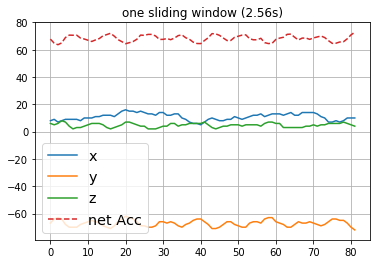

In [4]:
# choose a activity type, 0:a, 1:b, 2:c, 3:x
acti = 2
# choose the starting point to plot a sliding window
t = 10 # plot starts from t*2.5 sec

acc3axis_sample = Acc_rawdata_list[acti][t]
net_acc = np.sqrt(np.sum(acc3axis_sample**2,axis=1))

plt.figure()
plt.plot(acc3axis_sample[:,0],label='x',linestyle='-')
plt.plot(acc3axis_sample[:,1],label='y',linestyle='-')
plt.plot(acc3axis_sample[:,2],label='z',linestyle='-')
plt.plot(net_acc,label='net Acc',linestyle='--')
plt.legend(loc='best', fontsize='x-large')
plt.grid(True)
plt.title('one sliding window (2.56s)')


### Visualize group net Acc:

In [5]:
netAcc_mean_list=[] # store mean net Acc of 4 activities
netAcc_std_list=[] # store std net Acc of 4 activities
for i in range(len(Acc_2Drawdata_list)):
    Acc2D = Acc_2Drawdata_list[i]
    net_acc = np.sqrt(np.sum(Acc2D**2,axis=1))
    netAcc_mean = np.mean(net_acc)
    netAcc_std = np.std(net_acc)
    netAcc_mean_list.append(netAcc_mean)
    netAcc_std_list.append(netAcc_std)
    

<BarContainer object of 4 artists>

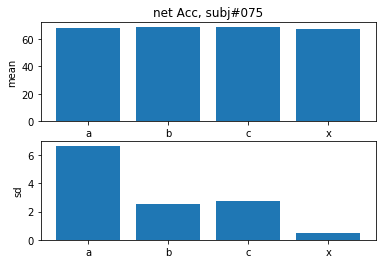

In [6]:
plt.figure()
plt.subplot(211)
xbar = ['a','b','c','x']
plt.bar(xbar, netAcc_mean_list)
plt.ylabel('mean')
plt.title('net Acc, subj#'+ subj)
plt.subplot(212)
plt.ylabel('sd')
plt.bar(xbar, netAcc_std_list)

### Re-scale our dataset:
To rescale the 3-axis amplitude of our dataset so that it match the trained dataset with the net Acc = 1 'g' (e.g., when laying).
I found that the mean of net ACC of our dataset is between 67 and 69 for all four activities. So, to be simple, let's set the scale efficient as 68.

In [7]:
scale = 68  # normalize our data to the unit: 'g'
Acc_rescaledata_list=[] # store data of 4 activities
for i in range(len(Acc_rawdata_list)):
    Acc1_3D = Acc_rawdata_list[i]
    Acc1_3D =Acc1_3D/scale
    Acc_rescaledata_list.append(Acc1_3D)

### Visualize one re-scaled sample:

Text(0.5, 1.0, 'one sliding window (2.56s)')

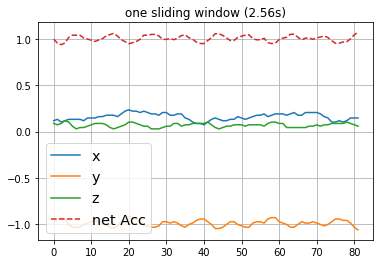

In [8]:
# choose a activity type, 0:a, 1:b, 2:c, 3:x
acti = 2
# choose the starting point to plot a sliding window
t = 10 # plot starts from t*2.5 sec

acc3axis_sample = Acc_rescaledata_list[acti][t]
net_acc = np.sqrt(np.sum(acc3axis_sample**2,axis=1))

plt.figure()
plt.plot(acc3axis_sample[:,0],label='x',linestyle='-')
plt.plot(acc3axis_sample[:,1],label='y',linestyle='-')
plt.plot(acc3axis_sample[:,2],label='z',linestyle='-')
plt.plot(net_acc,label='net Acc',linestyle='--')
plt.legend(loc='best', fontsize='x-large')
plt.grid(True)
plt.title('one sliding window (2.56s)')


## Load trainded model:

In [9]:
# Re-load the model with the best validation accuracy
model_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'LSTM_best_trained_model_3Acc_32Hz_90.1.h5'
best_model= keras.models.load_model(os.path.join(model_dir, model_name))


## Recognize our Acc data:

Text(0.5, 1.0, 'recoganize Acc data as:LAYING')

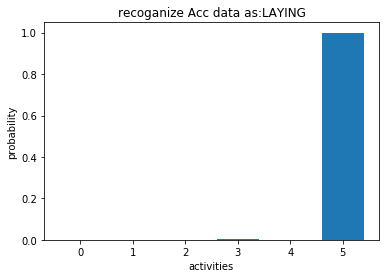

In [10]:
# choose an activity type, 0:a, 1:b, 2:c, 3:x
acti = 0
#X_test = Acc_rawdata_list[acti]
X_test = Acc_rescaledata_list[acti]

y_pre = best_model.predict(X_test)
y_pre_mean = np.mean(y_pre, 0)

# one of the following activity will be recognized by the trained model
ACTIVITIES = {
    0: 'WALK',
    1: 'WALK_UP',
    2: 'WALK_DOWN',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING'}

plt.figure()
plt.bar(range(6),y_pre_mean)
plt.xlabel('activities')
plt.ylabel('probability')
plt.title('recoganize Acc data as:'+ ACTIVITIES[np.argmax(y_pre_mean)])

## Conclusion:

Although the sampling ratio and amplitude scale of 3-axis accelerometer (Acc) data have been unified between the training dataset (UCI data) and the test dataset (our data), the well-trained model does not work on our dataset. It suggests a low generalization ability of the trained model. Two major reasons are (1) the different Acc data distribution and (2) the limitation of used neural net LSTM. 

However, there is a possible solution to improve the generalization ability of trained models: to reduce the variance of data (for training and testing). that is, to use only the net Acc might help to reduce such variance and worth a try as the plan B.
